In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Первичный анализ данных c Pandas
Считаем данные по росту и весу (*weights_heights.csv*) в объект Pandas DataFrame:

In [2]:
data = pd.read_csv('weights_heights.csv', index_col='Index')
data.head()

,Height,Weight
Index,,
1,65.78331,112.9925
2,71.51521,136.4873
3,69.39874,153.0269
4,68.21660,142.3354
5,67.78781,144.2971


Нарисуем гистограмму распределения веса с помощью метода *plot* Pandas DataFrame.

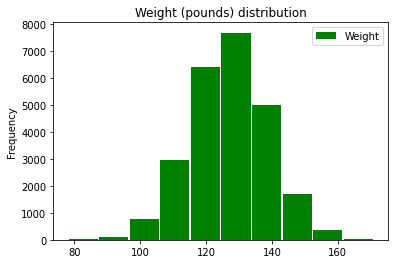

In [3]:
data.plot(y='Weight', kind='hist', rwidth=0.95, color='green',  title='Weight (pounds) distribution')
plt.show()

Создадим признак *Индекс массы тела* (BMI). Для этого воспользуемся удобной связкой метода *apply* Pandas DataFrame и lambda-функций Python.

In [4]:
def make_bmi(height_inch, weight_pound):
    METER_TO_INCH, KILO_TO_POUND = 39.37, 2.20462
    return (weight_pound / KILO_TO_POUND) / \
           (height_inch / METER_TO_INCH) ** 2

In [5]:
data['BMI'] = data.apply(lambda row: make_bmi(row['Height'], row['Weight']), axis=1)
data.head()

,Height,Weight,BMI
Index,,,
1,65.78331,112.9925,18.357573
2,71.51521,136.4873,18.762577
3,69.39874,153.0269,22.338895
4,68.21660,142.3354,21.504526
5,67.78781,144.2971,22.077581


Построим картинку, на которой будут отображены попарные зависимости признаков , 'Height', 'Weight' и 'BMI' друг от друга, используя метод *pairplot* библиотеки Seaborn.

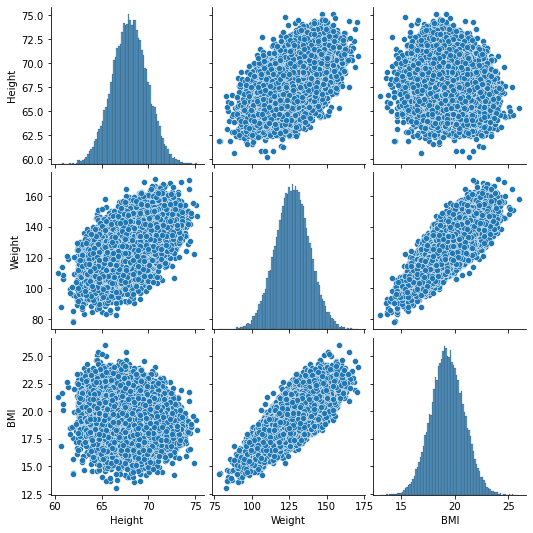

In [6]:
sns.pairplot(data)
plt.show()

Создим в DataFrame *data* новый признак *weight_category*, который будет иметь 3 значения: 1 – если вес меньше 120 фунтов. (~ 54 кг.), 3 - если вес  больше или равен 150 фунтов (~68 кг.), 2 – в остальных случаях. Построим «ящик с усами» (boxplot), демонстрирующий зависимость роста от весовой категории, используя метод *boxplot* библиотеки Seaborn и метод *apply* Pandas DataFrame.

In [7]:
def weight_category(weight):
    if weight < 120:
        return 1
    elif weight >= 150:
        return 3
    else:
        return 2

data['weight_cat'] = data['Weight'].apply(weight_category)
data.head()

,Height,Weight,BMI,weight_cat
Index,,,,
1,65.78331,112.9925,18.357573,1
2,71.51521,136.4873,18.762577,2
3,69.39874,153.0269,22.338895,3
4,68.21660,142.3354,21.504526,2
5,67.78781,144.2971,22.077581,2


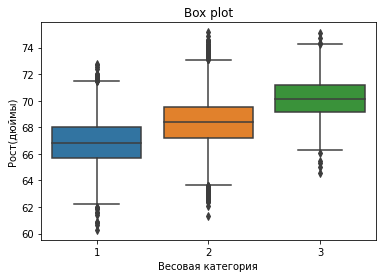

In [8]:
sns.boxplot(x='weight_cat', y='Height', data = data).set(title='Box plot',
                                                         xlabel='Весовая категория',
                                                         ylabel='Рост(дюймы)')
plt.show()

Построим scatter plot зависимости роста от веса, используя метод *plot* для Pandas DataFrame с аргументом *kind='scatter'*.

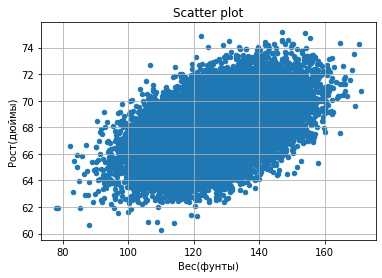

In [9]:
def scatter_plot():
    data.plot('Weight','Height', kind='scatter', grid=True).set(title='Scatter plot',
                                                                xlabel='Вес(фунты)',
                                                                ylabel='Рост(дюймы)')


scatter_plot()

## Минимизация квадратичной ошибки

Напишем функцию, которая по двум параметрам $w_0$ и $w_1$ вычисляет квадратичную ошибку приближения зависимости роста $y$ от веса $x$ прямой линией $y = w_0 + w_1 * x$:
$$error(w_0, w_1) = \sum_{i=1}^n {(y_i - (w_0 + w_1 * x_i))}^2 $$
Где $n$ – число наблюдений в наборе данных, $y_i$ и $x_i$ – рост и вес $i$-ого человека в наборе данных. 

In [10]:
def error(w):
    return data.apply(lambda row: (row['Height'] - (w[0] + w[1] * row['Weight'])) ** 2, axis=1).sum()
error([50, 0.14])

79997.73683208271

Проведем на графике *scatter_plot* две прямые, соответствующие значениям параметров ($w_0, w_1) = (60, 0.05)$ и ($w_0, w_1) = (50, 0.16)$, используя метод *plot* из *matplotlib.pyplot*, а также метод *linspace* библиотеки NumPy.

In [11]:
X = np.linspace(data['Weight'].min(), data['Weight'].max())

def line(w):
    return w[0] + w[1] * X


def line_scatter_plot(l1, l2=None):
    scatter_plot()
    plt.plot(X, line(l1), color='red', label=f'$(w_0, w_1) = ({l1[0]}, {l1[1]})$')
    if l2:
        plt.plot(X, line(l2), color='purple', label=f'$(w_0, w_1) = ({l2[0]}, {l2[1]})$')
    plt.legend(loc='best')

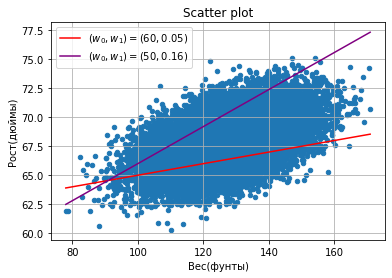

In [12]:
line_scatter_plot([60, 0.05], [50, 0.16])

Построим график зависимости функции ошибки (*error*), от параметра $w_1$ при $w_0$ = 50.

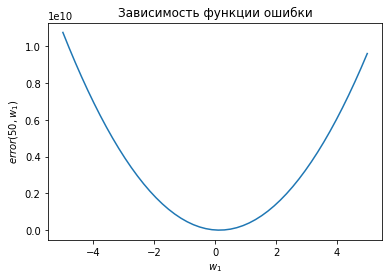

In [13]:
w1_range = np.linspace(-5, 5)
w1_error = [error([50, i]) for i in w1_range]
plt.plot(w1_range, w1_error)
plt.title('Зависимость функции ошибки')
plt.xlabel('$w_1$')
plt.ylabel('$error(50,w_1)$')
plt.show()

С помощью метода *minimize_scalar* из *scipy.optimize* найдем минимум функции *error*, для значений параметра  $w_1$ в диапазоне [-5,5].

In [14]:
import scipy.optimize as opt

def opt_error(x):
    return error([50,x])


res = opt.minimize_scalar(opt_error, bounds=(-5, 5), method='bounded')
w1_opt = res.x
res

     fun: 79512.217286995
 message: 'Solution found.'
    nfev: 6
  status: 0
 success: True
       x: 0.14109203728834374

Проведем на графике *scatter_plot* прямую, соответствующую значениям параметров ($w_0$, $w_1$) = (50, $w_1\_opt$), где $w_1\_opt$ – оптимальное значение параметра $w_1$. 

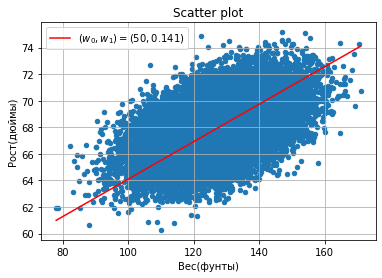

In [15]:
line_scatter_plot([50, round(w1_opt, 3)])

Постройте 3D-график зависимости функции ошибки, от параметров $w_0$ и $w_1$.

C:\Users\DEAD\AppData\Local\Temp/ipykernel_10612/1030102459.py:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


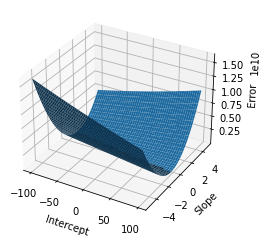

In [16]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.gca(projection='3d')

w_0 = np.arange(-100, 100)
w_1 = np.arange(-5, 5, 0.25)
w_0, w_1 = np.meshgrid(w_0, w_1)
Error = error([w_0, w_1])

surf = ax.plot_surface(w_0, w_1, Error)
ax.set_xlabel('Intercept')
ax.set_ylabel('Slope')
ax.set_zlabel('Error')
plt.show()

С помощью метода *minimize* из scipy.optimize найдем минимум функции *error*, для значений параметра $w_0$ в диапазоне [-100,100] и $w_1$ - в диапазоне [-5, 5], используя метод оптимизации L-BFGS-B (начальная точка – ($w_0$, $w_1$) = (0, 0)).

In [17]:
result = opt.minimize(error,[0,0],bounds=[(-100, 100),(-5,5)], method='L-BFGS-B')
w_opt = result.x
result

      fun: 67545.28708631505
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00145519, -0.00291038])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 36
      nit: 5
     njev: 12
   status: 0
  success: True
        x: array([57.57178029,  0.08200646])

Проведем на графике *scatter_plot* прямую, соответствующую найденным оптимальным значениям параметров $w_0$ и $w_1$.

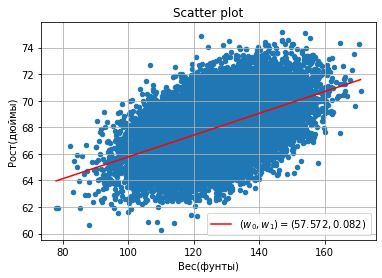

In [18]:
line_scatter_plot(np.around(w_opt, 3))